<a href="https://colab.research.google.com/github/edwinb-ai/segnet/blob/master/ejemplos/unet_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np

Using TensorFlow backend.


In [0]:
# Algunos hiperparámetros
epocas = 30
tam_lote = 2

In [0]:
%run "/content/drive/My Drive/Colab Notebooks/modelo.py"

In [0]:
%run "/content/drive/My Drive/Colab Notebooks/preprocesamiento.py"

In [0]:
%run "/content/drive/My Drive/Colab Notebooks/metricas.py"

In [0]:
# Extraer las imágenes y normalizar
X, y = extraer_datos(
    "/content/drive/My Drive/Colab Notebooks/dataset/train_images/train-volume.tif",
    "/content/drive/My Drive/Colab Notebooks/dataset/train_images/train-labels.tif"
)

In [0]:
x_patches, y_patches = muchas_imagenes_en_partes(
    X, y, size=(128, 128), num_partes=4
)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(x_patches, y_patches,
                                                 test_size=0.4,
                                                 random_state=15)

In [0]:
# Hacer aumento de datos simple
transformaciones = dict(
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=15.0,
    # randomly shift images horizontally
    width_shift_range=0.05,
    # randomly shift images vertically
    height_shift_range=0.05,
    # set range for random shear
    shear_range=50,
    # set range for random zoom
    zoom_range=0.2,
    fill_mode="constant",
    horizontal_flip=True,
    vertical_flip=False
)

In [0]:
# Conjunto de entrenamiento
entrenamiento = aumentar_imagenes_mascaras(X_train, y_train,
                                          transformaciones=transformaciones)

In [0]:
# Crear callbacks
guardar_modelo = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/unet_simple.h5",
                                 monitor="val_indice_jaccard",
                                 mode="max",
                                 verbose=1,
                                 save_best_only=True,
                                )
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              verbose=1,
                              mode="min",
                              patience=2,
                             )

In [0]:
# U-net
modelo_unet = unet(input_size=(128, 128, 1))
modelo_unet.compile(
    loss="binary_crossentropy",
    optimizer=SGD(1e-2, momentum=0.9),
    metrics=[indice_jaccard],
)

W0828 19:27:27.471009 140445076948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 19:27:27.490032 140445076948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 19:27:27.495389 140445076948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0828 19:27:27.525743 140445076948864 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0828 19:27:27.617675 140445076948864 deprecation_wrapp

In [0]:
modelo_unet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
historia = modelo_unet.fit_generator(
    entrenamiento,
    epochs=epocas,
    steps_per_epoch=100,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[guardar_modelo, reduce_lr],
)


Epoch 1/30
100/100 [==============================] - 32s 319ms/step - loss: 0.5798 - indice_jaccard: 0.4735 - val_loss: 0.5134 - val_indice_jaccard: 0.6024

Epoch 00001: val_indice_jaccard improved from -inf to 0.60241, saving model to /content/drive/My Drive/Colab Notebooks/unet_simple.h5
Epoch 2/30
100/100 [==============================] - 26s 260ms/step - loss: 0.4340 - indice_jaccard: 0.6023 - val_loss: 0.3977 - val_indice_jaccard: 0.6649

Epoch 00002: val_indice_jaccard improved from 0.60241 to 0.66492, saving model to /content/drive/My Drive/Colab Notebooks/unet_simple.h5
Epoch 3/30
100/100 [==============================] - 26s 260ms/step - loss: 0.3621 - indice_jaccard: 0.6652 - val_loss: 0.3638 - val_indice_jaccard: 0.7224

Epoch 00003: val_indice_jaccard improved from 0.66492 to 0.72239, saving model to /content/drive/My Drive/Colab Notebooks/unet_simple.h5
Epoch 4/30
100/100 [==============================] - 26s 259ms/step - loss: 0.3433 - indice_jaccard: 0.6908 - val_los

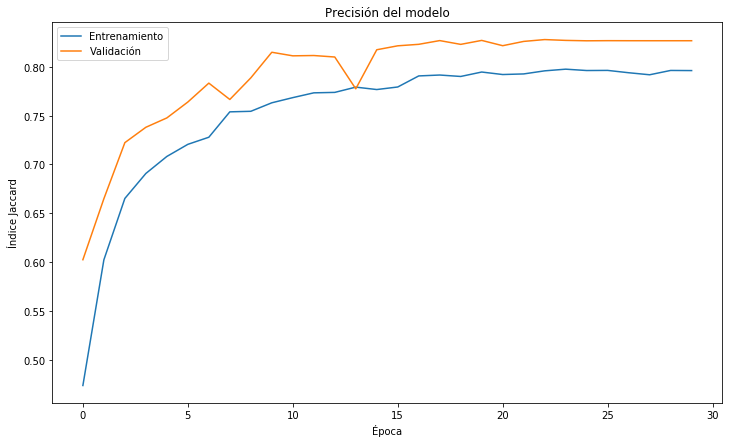

In [0]:
plt.figure(figsize=(12, 7))
plt.plot(historia.history["indice_jaccard"])
plt.plot(historia.history["val_indice_jaccard"])
plt.title("Precisión del modelo")
plt.ylabel("Índice Jaccard")
plt.xlabel("Época")
plt.legend(["Entrenamiento", "Validación"], loc="upper left")
plt.show()

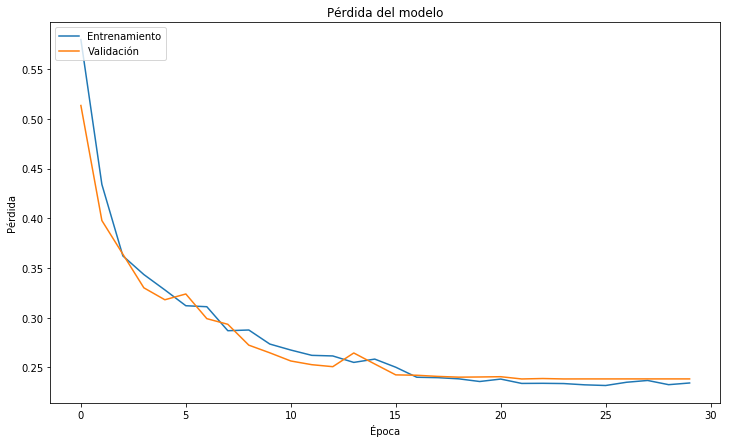

In [0]:
plt.figure(figsize=(12, 7))
plt.plot(historia.history["loss"])
plt.plot(historia.history["val_loss"])
plt.title("Pérdida del modelo")
plt.ylabel("Pérdida")
plt.xlabel("Época")
plt.legend(["Entrenamiento", "Validación"], loc="upper left")
plt.show()

In [0]:
X_test = datos_prueba("/content/drive/My Drive/Colab Notebooks/dataset/test_images/test-volume.tif")

In [0]:
mejor_modelo = unet(input_size=(512, 512, 1))
mejor_modelo.load_weights("/content/drive/My Drive/Colab Notebooks/unet_simple.h5")
resultados = mejor_modelo.predict(X_test, batch_size=tam_lote, verbose=1)
print(resultados.shape)

/content/drive/My Drive/Colab Notebooks/modelo.py:57: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input=inputs, output=conv10)


30/30 [==============================] - 17s 552ms/step
(30, 512, 512, 1)


In [0]:
from skimage.filters import threshold_otsu

In [0]:
thresh = threshold_otsu(resultados[1, :, :, 0])
binario = resultados[1, :, :, 0] > thresh

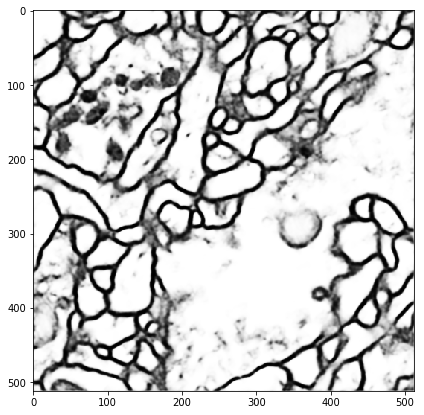

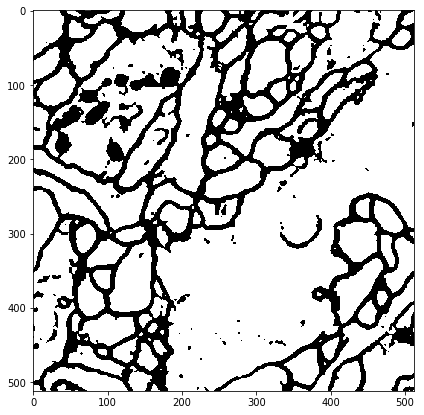

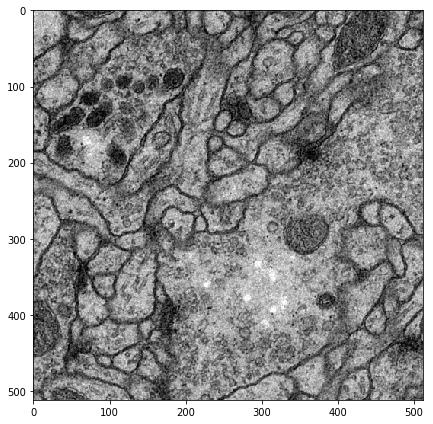

In [0]:
plt.figure(figsize=(12, 7))
plt.imshow(resultados[1, :, :, 0], cmap="gray")
plt.figure(figsize=(12, 7))
plt.imshow(binario, cmap="gray")
plt.figure(figsize=(10, 6))
io.imshow(X_test[1, :, :, 0])
io.show()